Assignment 3 -
Q3. This question has 3 parts.

1.	Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused?





In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Define transformations: convert to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
# Training
for epoch in range(51):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch%5 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}')


Epoch 0, Loss: 0.3994
Epoch 5, Loss: 0.0850
Epoch 10, Loss: 0.0510
Epoch 15, Loss: 0.0348
Epoch 20, Loss: 0.0261
Epoch 25, Loss: 0.0231
Epoch 30, Loss: 0.0213
Epoch 35, Loss: 0.0180
Epoch 40, Loss: 0.0155
Epoch 45, Loss: 0.0122
Epoch 50, Loss: 0.0141


In [6]:
model.eval()
mlp_preds = []
mlp_labels = []
from sklearn.metrics import accuracy_score

# Test loop
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        mlp_preds.extend(predicted.numpy())
        mlp_labels.extend(labels.numpy())

# Calculate F1-score and Confusion Matrix for MLP
print("MLP Accuracy:", accuracy_score(mlp_labels, mlp_preds))
print("MLP F1-Score:", f1_score(mlp_labels, mlp_preds, average='weighted'))
print("MLP Confusion Matrix:\n", confusion_matrix(mlp_labels, mlp_preds))


MLP Accuracy: 0.9762
MLP F1-Score: 0.9761791503526203
MLP Confusion Matrix:
 [[ 968    1    0    1    2    3    2    2    0    1]
 [   0 1132    1    1    0    0    1    0    0    0]
 [   2    3 1010    5    1    0    2    6    3    0]
 [   1    2    4  989    0    1    0    3    3    7]
 [   0    0    2    0  968    0    6    0    0    6]
 [   3    0    0   15    1  856    4    1    4    8]
 [   6    2    2    1    4    1  939    0    3    0]
 [   0    9   12    1    4    0    1  995    2    4]
 [   2    2    8   11    5    2    0    6  934    4]
 [   1    5    0    7   16    2    1    4    2  971]]


In [7]:
# Flatten data for scikit-learn models
x_train_flat = train_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
y_train = train_dataset.targets.numpy()
x_test_flat = test_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
y_test = test_dataset.targets.numpy()

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_flat, y_train)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, solver='saga', random_state=42)
lr_model.fit(x_train_flat, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [8]:
# Make predictions
rf_preds = rf_model.predict(x_test_flat)
lr_preds = lr_model.predict(x_test_flat)

# Calculate F1-scores and Confusion Matrices
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("Random Forest F1-Score:", f1_score(y_test, rf_preds, average='weighted'))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print("Logistic Regression F1-Score:", f1_score(y_test, lr_preds, average='weighted'))
print("LR Confusion Matrix:\n", confusion_matrix(y_test, lr_preds))


Random Forest Accuracy: 0.9704
Random Forest F1-Score: 0.9703722598097009
RF Confusion Matrix:
 [[ 971    0    0    0    0    2    3    1    3    0]
 [   0 1127    2    2    0    1    2    0    1    0]
 [   6    0 1002    5    3    0    3    8    5    0]
 [   1    0    9  972    0    9    0    9    8    2]
 [   1    0    0    0  955    0    5    1    4   16]
 [   5    1    1    9    2  860    5    2    5    2]
 [   7    3    0    0    3    3  937    0    5    0]
 [   1    4   20    2    0    0    0  989    2   10]
 [   4    0    6    7    5    5    5    4  930    8]
 [   7    6    2   12   12    1    0    4    4  961]]
Logistic Regression Accuracy: 0.9257
Logistic Regression F1-Score: 0.9255429483479441
LR Confusion Matrix:
 [[ 955    0    2    4    1   10    4    3    1    0]
 [   0 1111    4    2    0    2    3    2   11    0]
 [   6    9  930   14   10    3   12   10   34    4]
 [   4    1   16  925    1   23    2   10   19    9]
 [   1    3    7    3  921    0    6    5    6   30]


MLP can model non-linear relationships, making it more suited to handwritten digits.
Random Forest is better than Logistic Regression as it can handle non-linearities to some extent but lacks the hierarchical feature extraction of neural networks.
Logistic Regression performs the worst because it can’t capture the complexity of curved and overlapping shapes in handwritten digits.

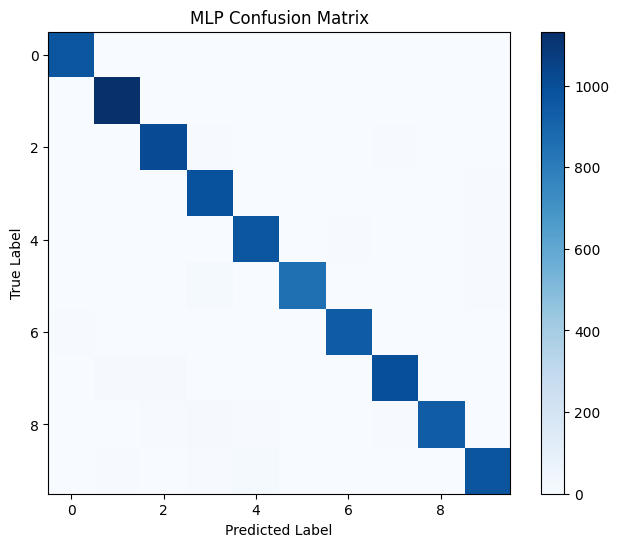

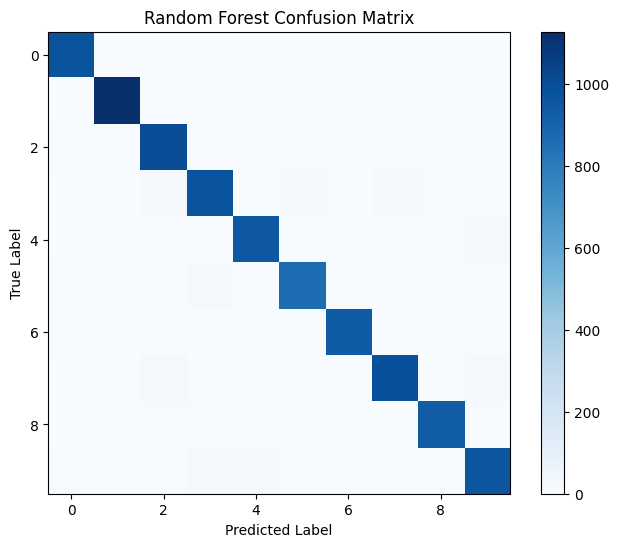

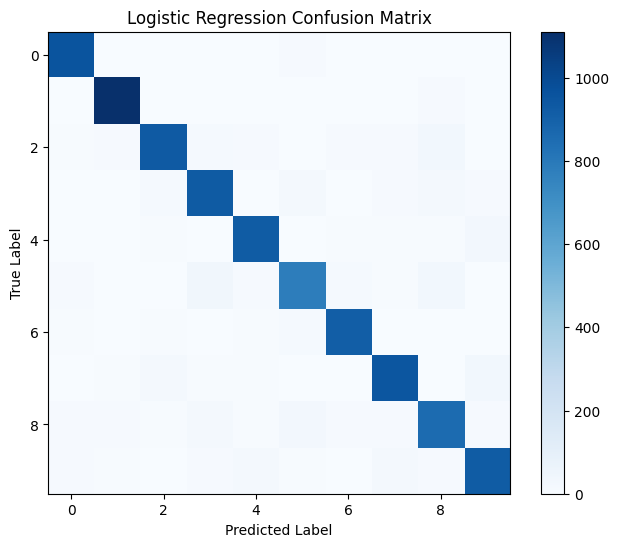

In [9]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(confusion_matrix(mlp_labels, mlp_preds), "MLP Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test, rf_preds), "Random Forest Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test, lr_preds), "Logistic Regression Confusion Matrix")


2.	Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude?



In [10]:
from sklearn.manifold import TSNE

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))  # Capture the activations here for t-SNE
        x = self.fc3(x)
        return x

trained_model = MLP()
untrained_model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=0.001)

# Training loop
for epoch in range(51):
    trained_model.train()
    total_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = trained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch%5 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}')


Epoch 0, Loss: 0.6017
Epoch 5, Loss: 0.1900
Epoch 10, Loss: 0.1460
Epoch 15, Loss: 0.1274
Epoch 20, Loss: 0.1155
Epoch 25, Loss: 0.1073
Epoch 30, Loss: 0.0994
Epoch 35, Loss: 0.0922
Epoch 40, Loss: 0.0880
Epoch 45, Loss: 0.0847
Epoch 50, Loss: 0.0798


In [12]:
# Helper function to extract activations from the 20-neuron layer
def get_activations(model, loader):
    model.eval()
    activations, labels = [], []

    with torch.no_grad():
        for images, lbls in loader:
            x = images.view(-1, 28 * 28)
            x = torch.relu(model.fc1(x))
            x = torch.relu(model.fc2(x))  # Activations we need
            activations.append(x.numpy())
            labels.append(lbls.numpy())

    # Combine all activations and labels into numpy arrays
    return np.concatenate(activations), np.concatenate(labels)


In [13]:
# Get activations from trained and untrained models
trained_activations, test_labels = get_activations(trained_model, test_loader)
untrained_activations, _ = get_activations(untrained_model, test_loader)


In [14]:
# Apply t-SNE to reduce the activations to 2D
tsne = TSNE(n_components=2, random_state=42)

trained_tsne_results = tsne.fit_transform(trained_activations)
untrained_tsne_results = tsne.fit_transform(untrained_activations)


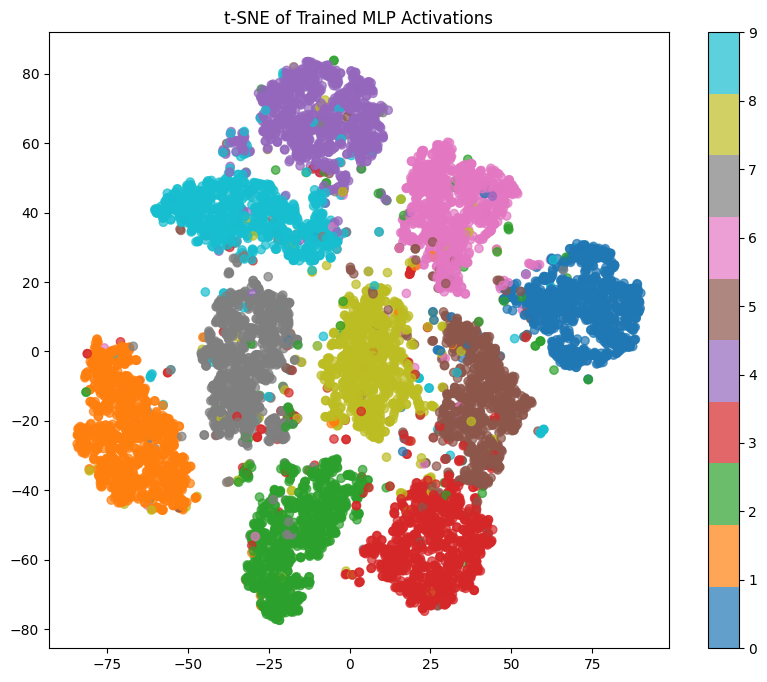

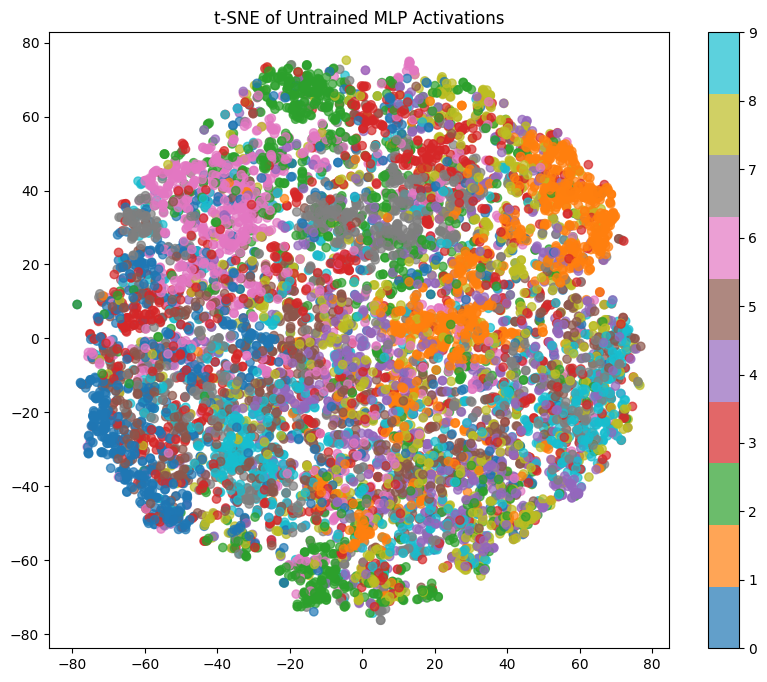

In [15]:
# Helper function to plot t-SNE results
def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.show()

# Plot t-SNE for trained model
plot_tsne(trained_tsne_results, test_labels, "t-SNE of Trained MLP Activations")

# Plot t-SNE for untrained model
plot_tsne(untrained_tsne_results, test_labels, "t-SNE of Untrained MLP Activations")


Trained MLP learns to extract meaningful features through its hidden layers. The 20-neuron layer captures intermediate-level features, and similar data points (like the same digits) are represented in nearby regions in the vector space.
Untrained MLP lacks any meaningful feature extraction, so its activations are random. The scattered t-SNE plot shows that the activations do not distinguish between different input classes.

3.	Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images)

In [17]:
from torchvision.datasets import FashionMNIST

# Load the Fashion-MNIST test dataset
fashion_test = FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_test_loader = torch.utils.data.DataLoader(fashion_test, batch_size=64, shuffle=False)

fashion_test


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [18]:
# Get predictions on Fashion-MNIST
fashion_preds, fashion_labels = [], []
fashion_preds1, fashion_labels1 = [], []

with torch.no_grad():
    for images, labels in fashion_test_loader:
        outputs = trained_model(images)  # Use the trained MLP model
        _, predicted = torch.max(outputs, 1)
        fashion_preds.extend(predicted.numpy())
        fashion_labels.extend(labels.numpy())

with torch.no_grad():
    for images, labels in fashion_test_loader:
        outputs = model(images)  # Use the trained MLP model
        _, predicted = torch.max(outputs, 1)
        fashion_preds1.extend(predicted.numpy())
        fashion_labels1.extend(labels.numpy())

# Calculate F1-score and Confusion Matrix for MLP
print("Accuracy:", accuracy_score(fashion_labels, fashion_preds))
print("F1-Score:", f1_score(fashion_labels, fashion_preds, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(fashion_labels, fashion_preds))

print("Accuracy:", accuracy_score(fashion_labels1, fashion_preds1))
print("F1-Score:", f1_score(fashion_labels1, fashion_preds1, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(fashion_labels1, fashion_preds1))


Accuracy: 0.0504
F1-Score: 0.04518692590169981
Confusion Matrix:
 [[  5   4  36  76   9  38   9  22 766  35]
 [495   1 186  11   2   1   1   2 243  58]
 [ 19   0  62  93  34 106 296   1 303  86]
 [  7   9 137  78   1  10  17   8 710  23]
 [ 14   0 127 134  15  24 187   2 435  62]
 [ 32  10 626  22  51 118  78  53   6   4]
 [  5   0  49 136  30  70  72   2 523 113]
 [  6   0 935   3   6   9  26  15   0   0]
 [ 31   1 148  50  48 291 155  60 137  79]
 [  2   8 515 304   1  62  86   6  15   1]]
Accuracy: 0.0449
F1-Score: 0.04447102756125918
Confusion Matrix:
 [[ 27  14  56  46   6  37   7  21 766  20]
 [ 78  12  79   1   2   1   1   1 775  50]
 [274   3  70 174  52   7  35   5 339  41]
 [ 14  40  36  54   9   6  10   2 824   5]
 [306   0  77  75  16   2  25   3 481  15]
 [197  31 343  27  63  89 167  56  24   3]
 [187   9  26  89  34   8  11  16 543  77]
 [ 10   1 677   1  11   1 261  36   2   0]
 [192   2 113  27  43 140 324  13 134  12]
 [  3   5 712 181   1   6  40   6  46   0]]


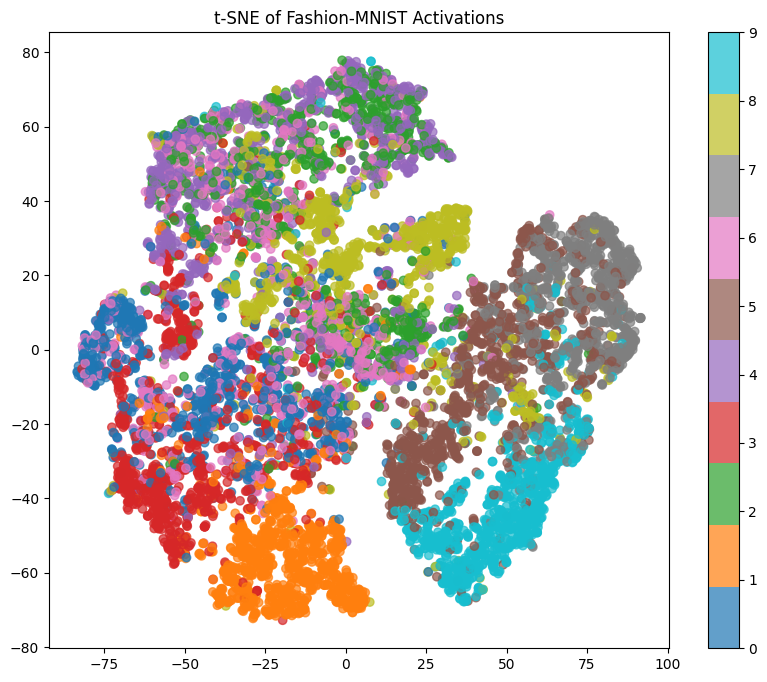

In [19]:
# Extract activations for Fashion-MNIST
fashion_activations, fashion_labels = get_activations(trained_model, fashion_test_loader)
fashion_tsne_results = tsne.fit_transform(fashion_activations)

# Plot the t-SNE results for Fashion-MNIST
plot_tsne(fashion_tsne_results, fashion_labels, "t-SNE of Fashion-MNIST Activations")


Since the MLP was trained on handwritten digits, it has learned digit-specific features (like loops, lines, and curves).
These features don’t generalize well to fashion items, which have very different visual characteristics.


The t-SNE plot for Fashion-MNIST shows some clusters for certain item categories because the MLP still has some general pattern recognition ability.
However, the clusters are less defined compared to MNIST since the model wasn’t trained on Fashion-MNIST data